In [2]:
%run data_cleaning.py  # clean and save the data

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from weighted_adj_mat import get_weighted_adjacency_matrix
from preprocessing import get_spatial_conv_multiplier, get_normalized_node_features, split_dataset
from model import STGCN
from run_model import run_model, unnormalize, prep_data

# set the features to be used as the model input
input_features = ['so2']#, 'pm10' 'pm25', 'so2', 'no2', 'o38h'

# Select the output feature as the index of the input_features list
output_feature_index = 0

num_timesteps_input = 14
num_timesteps_output = 1
num_prediction_steps = 1


epochs = 80
batch_size = 32
split_ratio = (0.6, 0.8)

learning_rate = 1e-3

dropout_rate = 0.2


device = 'cpu'

torch.manual_seed(7) # for reproducibility

In [3]:
#training_losses, validation_losses, means, stds, model, W =\

model, W, prefecture_names, means, stds, training_losses, validation_losses, test_data, data =\
    run_model(input_features, output_feature_index, num_timesteps_input, num_timesteps_output, 
              dropout_rate, learning_rate, epochs, batch_size, device, verbose=True, split_ratio=split_ratio)
    #run_model(input_features, num_timesteps_input, num_timesteps_output, 
    #          dropout_rate, learning_rate, epochs, batch_size, device, verbose=True, split_ratio=split_ratio)

num_nodes = len(prefecture_names)

# Short term prediction power
#input_unnormalized: unnormalized input of shape (num_samples, num_nodes, num_timesteps_input, num_features)
#prediction_unnormalized: unnormalized prediction of shape (num_samples, num_nodes, num_timesteps_output)
#target_unnormalized: unnormalized target of shape (num_samples, num_nodes, num_timesteps_output)



epochs:  0 Training loss: 0.9098437797455561 Validation loss: 0.470385879278183
epochs:  10 Training loss: 0.6041157713958195 Validation loss: 0.37658748030662537
epochs:  20 Training loss: 0.5637777284497306 Validation loss: 0.32902246713638306
epochs:  30 Training loss: 0.5502673025642123 Validation loss: 0.30988407135009766
epochs:  40 Training loss: 0.6953888961247036 Validation loss: 0.2834857702255249
epochs:  50 Training loss: 0.7316785596665882 Validation loss: 0.27545082569122314
epochs:  60 Training loss: 0.5124868339016324 Validation loss: 0.2935274541378021
epochs:  70 Training loss: 0.5117419078236535 Validation loss: 0.2770582437515259


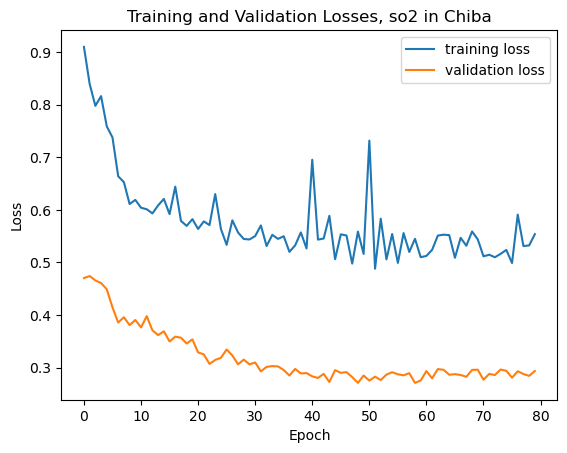

In [4]:
# Learning curve plotting
prefecture_index_example = 2

plt.plot(training_losses, label="training loss")
plt.plot(validation_losses, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses, "+input_features[output_feature_index] + " in " + prefecture_names[prefecture_index_example])
plt.legend()
plt.show() # Dropout can make validation loss smaller than training loss

In [5]:
# Short term prediction power
test_input = test_data['input']
prediction_short_term = test_data['prediction_unnormalized']
target_unnormalized = test_data['target_unnormalized']
test_timestamps = test_data['timestamps']

print('means', means, 'stds', stds, test_input.shape, prediction_short_term.shape, target_unnormalized.shape)
mape = mean_absolute_percentage_error(prediction_short_term.flatten(), target_unnormalized.flatten())
print('mape =', mape) # 15.6%, which is not bad

# Long term prediction power
test_input_begin = test_input[0,:,:,:] # shape (num_nodes, num_timesteps_input, num_features)

prediction_long_term = test_input_begin[:,:,output_feature_index] # shape (num_nodes, num_timesteps_input)


with torch.no_grad(): # Disable gradient calculation for evaluation
    model.eval() # Set model to evaluation mode
    
    num_iterations = int((target_unnormalized.shape[0] - num_timesteps_input)/num_prediction_steps)

    previous_days = test_input_begin.reshape(1, -1, num_timesteps_input, len(input_features)).to(device=device)

    W = W.to(device=device)

    # Iteratively generate the prediction for the next n days
    for i in range(num_iterations):

        # Predict next num_timesteps_output days
        prediction = model(W, previous_days) 

        previous_days = previous_days.detach().cpu().numpy() # (1, num_nodes, num_timesteps_input, num_features)
        prediction = prediction.detach().cpu() # (1, num_nodes, num_timesteps_output)

        prediction = prediction[:,:,:num_prediction_steps] # Concatenate only the first num_prediction_steps days

        prediction_long_term = torch.cat((prediction_long_term, prediction.reshape((num_nodes, -1))), dim=1)

        # Reshape to # (1, num_nodes, num_timesteps_output, num_features), where num_features =1 now
        prediction = prediction.numpy().reshape(prediction.shape + tuple((-1,)))

        # Concatenate the prediction with the input
        previous_days = np.concatenate((previous_days, prediction), axis=2)
        # Move forward num_prediction_steps days
        previous_days = torch.from_numpy(previous_days[:, :, -num_timesteps_input:, :]).to(device=device)
        #previous_days = torch.from_numpy(previous_days[:, :, num_prediction_steps:, :]).to(device=device)

prediction_long_term = unnormalize(prediction_long_term.numpy(), means[output_feature_index], stds[output_feature_index])

# Modify the array structure to be compatible with the timestamp order
target_unnormalized = np.array([target_unnormalized[i,:,0] for i in range(target_unnormalized.shape[0])])

# Match index andlength for plotting
total_prediction_days = prediction_long_term.shape[1]
timestemps = test_timestamps[0:total_prediction_days]
target_unnormalized = target_unnormalized[0:total_prediction_days,:]
prediction_long_term = prediction_long_term.transpose()

print(previous_days.shape, prediction.shape, prediction_long_term.shape, target_unnormalized.shape, timestemps.shape)



means [4.080315] stds [5.071315] torch.Size([205, 47, 14, 1]) (205, 47, 1) (205, 47, 1)
mape = 0.16110962629318237
torch.Size([1, 47, 14, 1]) (1, 47, 1, 1) (205, 47) (205, 47) (205,)


mape = 0.2796589136123657


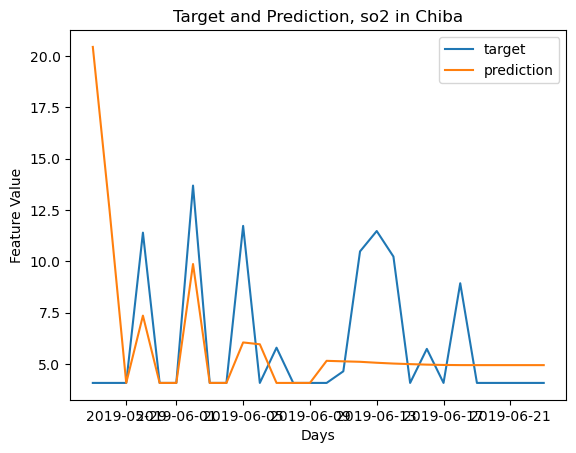

In [6]:
prefecture_index_example = 2
targets = target_unnormalized[:,prefecture_index_example]
predictions = prediction_long_term[:,prefecture_index_example]

ndays_to_plot = 28

mape = mean_absolute_percentage_error(targets.flatten(), predictions.flatten())
print('mape =', mape) # 15.6%, which is not bad

plt.plot(timestemps[:ndays_to_plot],targets[:ndays_to_plot], label="target")
plt.plot(timestemps[:ndays_to_plot],predictions[:ndays_to_plot], label="prediction")
plt.xlabel("Days")
plt.ylabel("Feature Value")
plt.title("Target and Prediction, "+input_features[output_feature_index] + " in " + prefecture_names[prefecture_index_example])
plt.legend()
plt.show() # 

0.2796589136123657 -0.18819653987884521


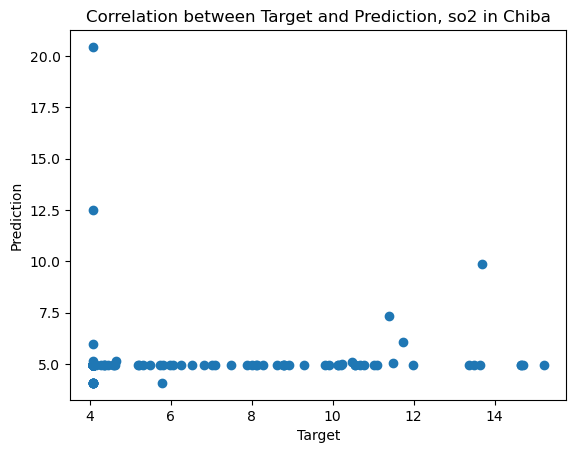

In [7]:
# Correlations
mape = mean_absolute_percentage_error(targets, predictions)
r2 = r2_score(targets, predictions)

print(mape, r2)

plt.scatter(targets, predictions)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title("Correlation between Target and Prediction, "+input_features[output_feature_index] + " in " + prefecture_names[prefecture_index_example])
plt.show() # 